## Réseaux de neurones avec couche d'embedding de Glove 
### DMOZ dataset


#### import des données et des packages 

In [39]:
import pandas as pd
import ast
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Input, Embedding,LSTM
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import os 
import tensorflow as tf 
import keras 



In [2]:
df = pd.read_csv("/home/ensai/imatag/website_categorization_custom/categorization/Datasets/dmoz.csv")


In [23]:
df=df.sample(frac=0.05)

In [24]:
texts=df['desc']
data_tokens=texts
y=df['category']

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

#### création de l'index de mots et de la matrice d'embedding avec glove 

In [25]:

X_train,X_test,Y_train,Y_test=train_test_split(data_tokens,y,test_size=0.30,stratify=y)


In [26]:
X_train.shape

(41855,)

In [27]:
path_to_glove_file = os.path.join(os.path.expanduser("~"), "imatag/website_categorization_custom/glove.6B.300d.txt")

#création de l'index du vocabulaire à partir du modèle Glove pour des vecteurs de taille 100
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs



In [28]:
#création du dictionnaire à partir de nos données
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


In [29]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

#Création de la matrice d'embedding
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 18978 words (1022 misses)


#### création de nos échantillons d'entraînement et de test 

In [30]:
X_train_vect=[]
for element in X_train:
    X_train_vect.append(vectorizer(np.array(element)).numpy())
X_train_vect=np.vstack(X_train_vect)

X_test_vect=[]
for element in X_test:
    X_test_vect.append(vectorizer(np.array(element)).numpy())
X_test_vect=np.vstack(X_test_vect)


Y_train_encode=pd.get_dummies(Y_train)
Y_test_encode=pd.get_dummies(Y_test)


#### Modèle de réseau de neurones 

In [1]:

model=Sequential()
model.add(Embedding(num_tokens,embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False, mask_zero=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=13,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

NameError: name 'Sequential' is not defined

In [42]:

history=model.fit(X_train_vect, Y_train_encode, batch_size=32, epochs=20, validation_data=(X_test_vect, Y_test_encode))


Epoch 1/20
1308/1308 [==============================] - 281s 212ms/step - loss: 1.3785 - accuracy: 0.5723 - val_loss: 1.0446 - val_accuracy: 0.6739
Epoch 2/20
1308/1308 [==============================] - 344s 263ms/step - loss: 1.0893 - accuracy: 0.6642 - val_loss: 0.9617 - val_accuracy: 0.6961
Epoch 3/20
1308/1308 [==============================] - 351s 269ms/step - loss: 1.0023 - accuracy: 0.6892 - val_loss: 0.9300 - val_accuracy: 0.7068
Epoch 4/20
1308/1308 [==============================] - 242s 185ms/step - loss: 0.9557 - accuracy: 0.7022 - val_loss: 0.9102 - val_accuracy: 0.7131
Epoch 5/20
1308/1308 [==============================] - 244s 187ms/step - loss: 0.9095 - accuracy: 0.7155 - val_loss: 0.8907 - val_accuracy: 0.7156
Epoch 6/20
1308/1308 [==============================] - 243s 186ms/step - loss: 0.8823 - accuracy: 0.7224 - val_loss: 0.8836 - val_accuracy: 0.7183
Epoch 7/20
1308/1308 [==============================] - 244s 186ms/step - loss: 0.8518 - accuracy: 0.7317 - val_

KeyboardInterrupt: 

In [36]:
loss, accuracy = model.evaluate(X_train_vect, Y_train_encode, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_vect, Y_test_encode, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7397
Testing Accuracy:  0.6954


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


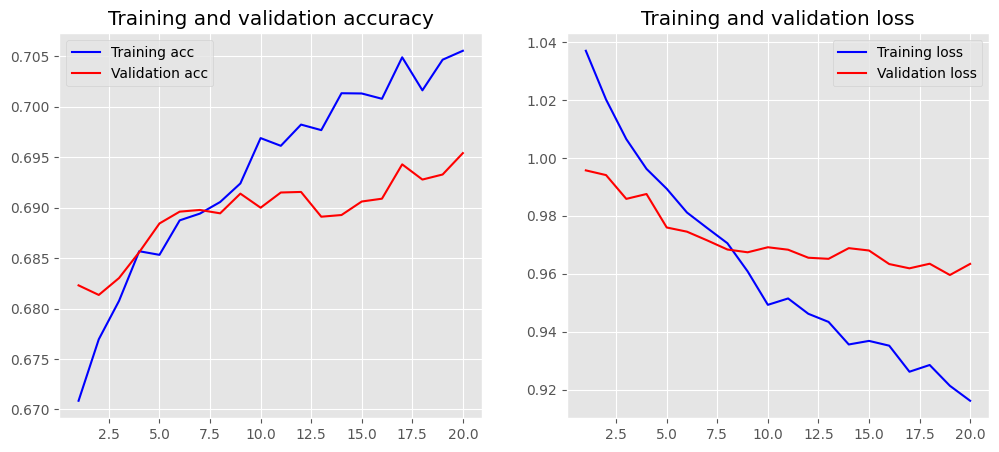

In [37]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy
y_pred=model.predict(x_test)
y_pred_label=np.array([labels.columns[[y_pred[i].argmax()]][0] for i in range(y_test.shape[0])])
y_test_label=np.array([labels.columns[[y_test.iloc[i].argmax()]][0] for i in range(y_test.shape[0])])
confusion_matrix = metrics.confusion_matrix(y_test_label, y_pred_label)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test_label, y_pred_label,xticks_rotation='vertical')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 

NameError: name 'x_test' is not defined